# import, set sampler

In [1]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [4]:
# f1 = open("token.txt", "r")
f2 = open("../paid_token.txt", "r")
# freetoken=f1.read()
paidtoken=f2.read()

#sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=freetoken)
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=paidtoken)

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# get nodes and coups

In [5]:
#get the couplers and nodes classification
with open('nodes_class.pkl', 'rb') as file:
    nodes_class = pickle.load(file)
with open('coups_class.pkl', 'rb') as file:
    coups_class = pickle.load(file)

#check J_11, 12 and 22 couplers
count = [0,0,0,0]
for coup in coups_class:
    if coups_class[coup]=='K2':
        count[0] += 1
        #final_coups.update({coup:k2})
    elif coups_class[coup]=='J11':
        count[1] += 1
        #final_coups.update({coup:jafm})
    elif coups_class[coup]=='J12':
        count[2] += 1
        #final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
    elif coups_class[coup]=='J22':
        count[3] += 1
        #final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
    else:
        print("error")
print(count)

[45, 319, 102, 9]


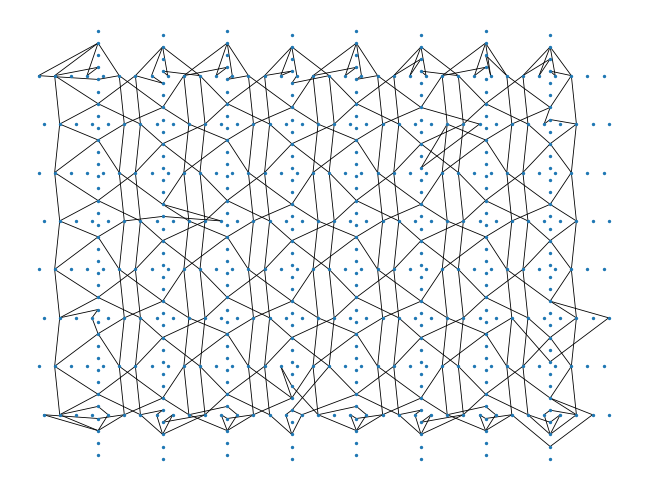

In [6]:
import dwave_networkx as dnx

G_graph = dnx.zephyr_graph(m=4, edge_list=coups_class.keys())
#G_graph.add_edges_from(coups_class.keys())
dnx.draw_zephyr(
    G_graph,
    node_size = 2,
    font_size = 5,
    width = 0.6
)

In [7]:
G_graph.edges

EdgeView([(0, 296), (0, 320), (7, 552), (7, 544), (8, 296), (8, 12), (8, 336), (8, 312), (9, 360), (9, 12), (9, 13), (9, 400), (10, 424), (10, 13), (10, 464), (10, 14), (11, 15), (11, 528), (11, 488), (11, 14), (12, 360), (12, 336), (13, 424), (13, 400), (14, 464), (14, 472), (15, 552), (15, 528), (15, 536), (24, 296), (24, 312), (30, 472), (30, 488), (39, 552), (39, 536), (40, 296), (40, 44), (40, 340), (40, 320), (41, 44), (41, 360), (41, 45), (41, 404), (42, 424), (42, 46), (42, 468), (42, 45), (43, 46), (43, 47), (43, 532), (43, 488), (44, 360), (44, 340), (45, 424), (45, 412), (46, 468), (46, 488), (47, 552), (47, 532), (47, 544), (48, 336), (48, 52), (48, 300), (48, 324), (49, 400), (49, 52), (49, 364), (49, 53), (50, 464), (50, 53), (50, 428), (50, 54), (51, 528), (51, 54), (51, 492), (51, 55), (52, 336), (52, 364), (53, 400), (53, 428), (54, 464), (54, 492), (55, 528), (55, 556), (55, 540), (56, 300), (56, 324), (63, 556), (63, 540), (64, 300), (64, 316), (71, 556), (71, 548), 

# functions

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

In [10]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [11]:
def DocName(jafm,k2,h1,s):
    
    str1="J="+str(jafm)
    str2="h1,k2,s="+str(h1)+","+str(k2)+","+str(s)
    now = datetime.now()
    str3 = now.strftime("%m-%d-%y__%H-%M-%S")
    
    Documentname=str1+'__'+str2+'__'+str3
    
    return Documentname

# anneal offsets

In [15]:
data = pd.read_excel('../data/annealing_schedule.xlsx',  sheet_name='processor-annealing-schedule') 
s_vals = pd.DataFrame(data, columns=['s'])
A_vals = pd.DataFrame(data, columns=['A(s) (GHz)'])
B_vals = pd.DataFrame(data, columns=['B(s) (GHz)'])
cs_vals = pd.DataFrame(data, columns=['C (normalized)'])
first_s = s_vals.to_numpy().flatten()
first_A = A_vals.to_numpy().flatten()
first_B = B_vals.to_numpy().flatten()
first_c = cs_vals.to_numpy().flatten()


In [16]:
new_s = np.linspace(0,1,num = 100*len(first_s))
new_A = np.interp(new_s, first_s, first_A)
new_B = np.interp(new_s, first_s, first_B)
new_c = np.interp(new_s, first_s, first_c)

A2divB = np.divide(new_A**2,new_B)

indices = len(new_A)*np.ones(len(new_A),dtype=np.int8)
# delta_c = np.zeros(len(new_A))
differences = np.zeros(len(new_A))

for i in range(len(new_A)):
    val = find_nearest(A2divB, value = new_A[i])
    differences[i]= A2divB[val] - new_A[i]
    indices[i] = val 
    

In [17]:
hoffset_s = np.divide(new_B,2*new_B[indices])
J22_s = np.divide(new_B,new_B[indices])
J12_s = np.divide(2*new_B,new_B + new_B[indices])
delta_c = new_c[indices] - new_c


# params

In [30]:

splist=np.linspace(0.2,0.95,16)
#splist = [0.5]
print('s_p = ')
print(splist)
Nreads=850
Nreps = 1
#h_list = [1.0, 1.5, 2.0, 2.5, 3.0] #this is h/J
h_list = [3.75]
#h_list = np.linspace(0.0,4.0,17)
print('h/J = ')
print(h_list)

#careful prathu with folder structure

folder_allin = "./data/raw_apq_v4/"
folder_create = Path(folder_allin[:-1])
folder_create.mkdir(parents=True, exist_ok=True)

s_p = 
[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85
 0.9  0.95]
h/J = 
[3.75]


# time estimate

In [31]:

times_big = []

for h1_run in h_list:

    h1val = h1_run/np.max(J22_s)
    times = []
        
    for j in range(len(splist)):
        sp = splist[j]
    #         print("sp=",sp)
        spindex = find_nearest(new_s, sp)
        jafm = 1.0/np.max(J22_s)
        k2 = -2.0


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = sampler.nodelist.index(node)
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]
                    
        time_allreps=[]
        for rep in range(Nreps):                
            time =  sampler.solver.estimate_qpu_access_time(
                    num_qubits=len(final_nodes),
                    anneal_schedule=anneal_pause_quench_sch,
                    num_reads=Nreads,
                    answer_mode = "raw")
            
            if time > 1000000:
                    print("time for Nreads=", Nreads, "is more than 1 second:",
                            time)
            time_allreps.append(time)

                
        times.append(sum(time_allreps))
        #print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
    print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

h1= 2.4801381361443924 time= 10117757.777347414

anneal pause quench anneal access time 10.117757777347414 seconds 0.16862929628912357 minutes
all done


# anneal pause quench

In [32]:

times_big = []

for h1_run in h_list:

    h1val = h1_run/np.max(J22_s)
    times = []
    print("start h1=", h1val)

    folder = Path(folder_allin + "h=" + str(h1val))
    folder.mkdir(parents=True, exist_ok=True)
    
        
    for j in range(len(splist)):
        sp = splist[j]
        spindex = find_nearest(new_s, sp)
        jafm = 1.0/np.max(J22_s)
        k2 = -2.0
        print("start s_p=", sp)

        folder_s = Path(folder_allin + "h=" + str(h1val) + "/sp=" + str(sp))
        folder_s.mkdir(parents=True, exist_ok=True)


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = sampler.nodelist.index(node)
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]
                    
        time_allreps=[]
        for rep in range(Nreps):                
            response =  sampler.sample_ising(
                        h=final_hs,
                        J=final_coups,
                        anneal_schedule=anneal_pause_quench_sch,
                        num_reads=Nreads)
            time = response.info['timing']['qpu_access_time']
            time_allreps.append(time)

            #folder = Path(
            #    "/Users/prathunarasimhan/Library/CloudStorage/GoogleDrive-pn187@scarletmail.rutgers.edu/My Drive/Kagome data /periodic Kagome fwd4/raw"
            #    + "/" + "h1=" + str(h1val))

            #Name = DocName(jafm, k2, h1val, sp)
            #filepath = Path(folder, Name)

            #careful prathu with folder structure
            filepath = folder_allin + "h=" + str(h1val) + "/sp=" + str(sp) + "/data_at_Rep=" + str(rep)

            paramsarray = set_params_array({
                    'jafm': jafm,
                    'k2': k2,
                    'h1': h1val,
                    'Nreads': Nreads,
                    'sp' : sp
                })
            
            resp = response.record
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes=final_nodes,
            )

                
        times.append(sum(time_allreps))
        print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

start h1= 2.4801381361443924
start s_p= 0.2
s_p= 0.2 time= 311436.61
start s_p= 0.25
s_p= 0.25 time= 353886.41
start s_p= 0.30000000000000004
s_p= 0.30000000000000004 time= 396350.41
start s_p= 0.35000000000000003
s_p= 0.35000000000000003 time= 438817.61
start s_p= 0.4
s_p= 0.4 time= 481267.01
start s_p= 0.45
s_p= 0.45 time= 523717.21
start s_p= 0.5
s_p= 0.5 time= 566183.21
start s_p= 0.55
s_p= 0.55 time= 608631.41
start s_p= 0.6000000000000001
s_p= 0.6000000000000001 time= 651097.81
start s_p= 0.65
s_p= 0.65 time= 693546.81
start s_p= 0.7
s_p= 0.7 time= 736012.81
start s_p= 0.75
s_p= 0.75 time= 778461.81
start s_p= 0.8
s_p= 0.8 time= 820927.81
start s_p= 0.8500000000000001
s_p= 0.8500000000000001 time= 863377.21
start s_p= 0.9000000000000001
s_p= 0.9000000000000001 time= 905842.41
start s_p= 0.95
s_p= 0.95 time= 948292.21
h1= 2.4801381361443924 time= 10077848.760000002

anneal pause quench anneal access time 10.077848760000002 seconds 0.16796414600000004 minutes
all done


# measuring in the X basis?

In [5]:
test_sp = 0.5
basic_schedule = [[0.0, 0.0], [1000*test_sp, test_sp], [100 + 1000*test_sp, test_sp],
                    [100 + 1000*test_sp + (1-test_sp), 1]]
X_wait_time = 1

def zx_schedule_fct(test_sp, X_wait_time):
    return [[0.0, 0.0], [1000*test_sp, test_sp], [100 + 1000*test_sp, test_sp], [100 + 1000*test_sp + test_sp, 0], [100 + 1000*test_sp + test_sp + X_wait_time, 0], [100 + 1000*test_sp + test_sp + 1 + X_wait_time, 1]]


def zx_h_schedule(test_sp, X_wait_time):
    return [[0.0, 1.0], [1000*test_sp, 1.0], [100 + 1000*test_sp, 1.0], [100 + 1000*test_sp + test_sp, 0], [100 + 1000*test_sp + test_sp + X_wait_time, 0], [100 + 1000*test_sp + test_sp + 1 + X_wait_time, 0]]

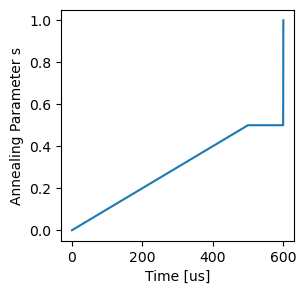

In [11]:
zx_schedule = zx_schedule_fct(test_sp, 10)
h_schedule = zx_h_schedule(test_sp, 10)
#plot it
plt.figure(figsize=(3,3))
ax = plt.gca()
# ax.set_title("Schedule Comparison")
ax.plot([basic_schedule[i][0] for i in range(len(basic_schedule))], [basic_schedule[i][1] for i in range(len(basic_schedule))], label = 'original schedule')
# ax.plot([zx_schedule[i][0] for i in range(len(zx_schedule))], [zx_schedule[i][1] for i in range(len(zx_schedule))], label = 'global X pulse')
# ax.plot([h_schedule[i][0] for i in range(len(h_schedule))], [h_schedule[i][1] for i in range(len(h_schedule))], label = 'h gain schedule')
# plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [133]:

splist=np.linspace(0.05,0.95,11)
#splist = [0.5]
print('s_p = ')
print(splist)
Nreads=100
Nreps = 1
#h_list = [1.0, 1.5, 2.0, 2.5, 3.0] #this is h/J
#h_list = [0.5]
h_list = [0.0, 0.5, 1.5, 2.0, 3.0]
print('h/J = ')
print(h_list)
pulse_pause = 0.01

folder_allin = "./data/raw_apq_zx/"
folder_create = Path(folder_allin[:-1])
folder_create.mkdir(parents=True, exist_ok=True)

s_p = 
[0.05 0.14 0.23 0.32 0.41 0.5  0.59 0.68 0.77 0.86 0.95]
h/J = 
[0.0, 0.5, 1.5, 2.0, 3.0]


time estimate

In [134]:

times_big = []

for h1_run in h_list:

    h1val = h1_run/np.max(J22_s)
    times = []
        
    for j in range(len(splist)):
        sp = splist[j]
    #         print("sp=",sp)
        spindex = find_nearest(new_s, sp)
        jafm = 1.0/np.max(J22_s)
        k2 = -2.0


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = sampler.nodelist.index(node)
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = zx_schedule_fct(sp, pulse_pause)
                    
        time_allreps=[]
        for rep in range(Nreps):                
            time =  sampler.solver.estimate_qpu_access_time(
                    num_qubits=len(final_nodes),
                    anneal_schedule=anneal_pause_quench_sch,
                    num_reads=Nreads,
                    answer_mode = "raw")
            
            if time > 1000000:
                    print("time for Nreads=", Nreads, "is more than 1 second:",
                            time)
            time_allreps.append(time)

                
        times.append(sum(time_allreps))
        #print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
    print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

h1= 0.0 time= 800285.4731678051

h1= 0.3306850848192523 time= 800285.4731678051

h1= 0.9920552544577569 time= 800285.4731678051

h1= 1.3227403392770092 time= 800285.4731678051

h1= 1.9841105089155138 time= 800285.4731678051

anneal pause quench anneal access time 4.001427365839025 seconds 0.0666904560973171 minutes
all done


the run itself

In [135]:

times_big = []

for h1_run in h_list:

    h1val = h1_run/np.max(J22_s)
    times = []
    print("start h1=", h1val)

    folder = Path(folder_allin + "h=" + str(h1val))
    folder.mkdir(parents=True, exist_ok=True)
    
        
    for j in range(len(splist)):
        sp = splist[j]
        spindex = find_nearest(new_s, sp)
        jafm = 1.0/np.max(J22_s)
        k2 = -2.0
        print("start s_p=", sp)

        folder_s = Path(folder_allin + "h=" + str(h1val) + "/sp=" + str(sp))
        folder_s.mkdir(parents=True, exist_ok=True)


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = sampler.nodelist.index(node)
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = zx_schedule_fct(sp,pulse_pause)
        h_gain_schedule= zx_h_schedule(sp, pulse_pause)
                    
        time_allreps=[]
        for rep in range(Nreps):                
            response =  sampler.sample_ising(
                        h=final_hs,
                        J=final_coups,
                        anneal_schedule=anneal_pause_quench_sch,
                        h_gain_schedule=h_gain_schedule, 
                        num_reads=Nreads)
            time = response.info['timing']['qpu_access_time']
            time_allreps.append(time)

            #folder = Path(
            #    "/Users/prathunarasimhan/Library/CloudStorage/GoogleDrive-pn187@scarletmail.rutgers.edu/My Drive/Kagome data /periodic Kagome fwd4/raw"
            #    + "/" + "h1=" + str(h1val))

            #Name = DocName(jafm, k2, h1val, sp)
            #filepath = Path(folder, Name)
            filepath = folder_allin + "h=" + str(h1val) + "/sp=" + str(sp) + "/data_at_Rep=" + str(rep)

            paramsarray = set_params_array({
                    'jafm': jafm,
                    'k2': k2,
                    'h1': h1val,
                    'Nreads': Nreads,
                    'sp' : sp
                })
            
            resp = response.record
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes=final_nodes,
            )

                
        times.append(sum(time_allreps))
        print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

start h1= 0.0
start s_p= 0.05
s_p= 0.05 time= 27707.61
start s_p= 0.14
s_p= 0.14 time= 36715.61
start s_p= 0.22999999999999998
s_p= 0.22999999999999998 time= 45726.41
start s_p= 0.32
s_p= 0.32 time= 54734.81
start s_p= 0.41
s_p= 0.41 time= 63746.01
start s_p= 0.49999999999999994
s_p= 0.49999999999999994 time= 72756.01
start s_p= 0.5900000000000001
s_p= 0.5900000000000001 time= 81765.21
start s_p= 0.68
s_p= 0.68 time= 90773.21
start s_p= 0.77
s_p= 0.77 time= 99783.21
start s_p= 0.86
s_p= 0.86 time= 108790.81
start s_p= 0.95
s_p= 0.95 time= 117800.81
h1= 0.0 time= 800299.7100000002
start h1= 0.3306850848192523
start s_p= 0.05
s_p= 0.05 time= 27708.81
start s_p= 0.14
s_p= 0.14 time= 36716.01
start s_p= 0.22999999999999998
s_p= 0.22999999999999998 time= 45725.21
start s_p= 0.32
s_p= 0.32 time= 54734.81
start s_p= 0.41
s_p= 0.41 time= 63746.81
start s_p= 0.49999999999999994
s_p= 0.49999999999999994 time= 72756.81
start s_p= 0.5900000000000001
s_p= 0.5900000000000001 time= 81766.81
start s_p